# PruneTrain for fast sparse training experiments

Implement [PruneTrain: Fast Neural Network Training by Dynamic Sparse Model Reconfiguration](https://arxiv.org/abs/1901.09290) to evaluate train time reduction of training a model from scratch while inducing sparsity.

In [1]:
%matplotlib inline
# automatically reload modified Python modules before executing a code cell
%reload_ext autoreload
%autoreload 2

In [2]:
# set NVidia Tesla V100 GPU clock speed to the maximum
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:04.0
All done.


In [3]:
!nvidia-smi

Fri Sep 20 07:37:59 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    45W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!cat /proc/cpuinfo | grep -E 'processor|model name|cpu MHz|cache size'

processor	: 0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 1
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 2
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 3
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 4
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 5
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 6
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB
processor	: 7
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.168
cache size	: 56320 KB


In [5]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          52339         487       51348          11         503       51324
Swap:             0           0           0


In [6]:
# use all Web browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

In [7]:
from datetime import datetime
from time import time

import pandas as pd
import torch
import joblib

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import fastai
from fastai.callbacks import * 
# from fastai.callbacks.mem import PeakMemMetric
from fastai.vision import *
# from fastai.metrics import error_rate

from core import build_graph, DotGraph
from torch_backend import build_flat_modules, build_flat_model
from fastai_backend import SparsityChannelsMetric, LowestMaxChannelWeightMetric, ModelPruner, TrainTimeMetric, PeakMemMetric
from prunetrain import compute_group_lasso_penalty, count_channels, GroupLassoLoss, mark_layers, model_summary, print_back_graph

# from resnet import ResNet32
from vgg import VGG8, VGG16

In [8]:
from fastai.utils.show_install import show_install; show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.54
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u3 (2019-06-16)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/cifar10-fast
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload

/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be install

## Code

In [9]:
def fmt_now():
    return datetime.today().strftime('%Y%m%d-%H%M%S')

In [10]:
def plot_two_scales(a, b, label_a, label_b, title, label_x, ax):
    """Plot two series with different y axis
    See https://matplotlib.org/gallery/api/two_scales.html
    """
    ax.plot(a, label=label_a)
    ax.tick_params(axis='y', labelcolor="b")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(label_x)

    # create 2nd y axis
    axy2 = ax.twinx()
    axy2.plot(b, label=label_b, color="orange")
    axy2.tick_params(axis='y', labelcolor="orange")
    
    # custom legend, see https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    legend_elements = [Line2D([0], [0], color="b", label=label_a),
                       Line2D([0], [0], color="orange", label=label_b),]
    ax.legend(handles=legend_elements)
    
    return ax, axy2

In [11]:
def plot_training(summary):
    """Plot graphes of training metrics"""
    s = pd.DataFrame(summary)
    
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    # plot train and test time using 2 y axis
    plot_two_scales(s["train time"], s["test time"], "train time", "test time", title="train/test time (s)", label_x="epoch", ax=axs[0])

    # plot # channels and lasso penalty value
    max_sparsity = s["sparsity"].max() * 100
    plot_two_scales(s["channels"], s["train lasso"], "channels", "train lasso", title=f"sparsity (max={max_sparsity:2.2f}%)", label_x="epoch", ax=axs[1])

    # accuracy
    s[["train acc", "test acc"]].plot(ax=axs[2])
    max_acc = s["test acc"].max()
    axs[2].set_title(f"accuracy (max={max_acc:0.4f})", fontsize=16)
    axs[2].set_xlabel("epoch")

    fig.tight_layout()

In [12]:
def find_lr(learn):
    """Search for the best learning rate given the model and data"""
    learn.lr_find()
    learn.recorder.plot()

In [13]:
def save_recorder_state(rec, save_name):
    """Save Leaner's Recorder state to file"""
    rec_state = {}
    for attr in ["metrics_names", "losses", "val_losses", "lrs", "moms", "metrics", "nb_batches"]:
        rec_state[attr] = getattr(rec, attr)
        
    fname = f"{fmt_now()}_recorder_{save_name}.lzma"
    return joblib.dump(rec_state, fname)

In [14]:
def load_recorder_state(rec, fname):
    rec_state = joblib.load(fname)
    for attr in ["metrics_names", "losses", "val_losses", "lrs", "moms", "metrics", "nb_batches"]:
        setattr(rec, attr, rec_state[attr])

## Load datasets

### CIFAR-10 dataset

In [15]:
cifar10_path = untar_data(URLs.CIFAR);
print(cifar10_path)
cifar10_path.ls()

/home/jupyter/.fastai/data/cifar10


[PosixPath('/home/jupyter/.fastai/data/cifar10/labels.txt'),
 PosixPath('/home/jupyter/.fastai/data/cifar10/test'),
 PosixPath('/home/jupyter/.fastai/data/cifar10/models'),
 PosixPath('/home/jupyter/.fastai/data/cifar10/train')]

In [16]:
def create_cifar10_databunch(tfms, bs=256):
    data = ImageDataBunch.from_folder(cifar10_path, ds_tfms=tfms, valid='test', size=24, bs=bs)
    data.normalize(cifar_stats)
    return data

In [17]:
tfms_nop = ([], [])
tfms_pad_flip = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
tfms_pad_flip_cutout = ([*rand_pad(4, 32), flip_lr(p=0.5), cutout(n_holes=(1, 1), length=(8, 8), p=1)], [])

In [18]:
data = create_cifar10_databunch(tfms=tfms_nop)

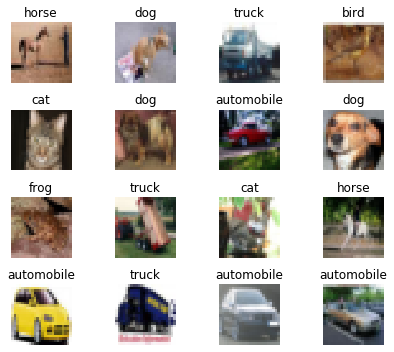

In [19]:
data.show_batch(rows=4, figsize=(6, 5))

## Imagenette dataset

[Imagenette](https://github.com/fastai/imagenette) is:
> A subset of 10 easily classified classes from Imagenet: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute

In [20]:
imagenette_path = untar_data(URLs.IMAGENETTE_160);
print(imagenette_path)
imagenette_path.ls()

/home/jupyter/.fastai/data/imagenette-160


[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/models'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/train')]

In [21]:
def create_imagenette_databunch(tfms, bs=256):
    data = ImageDataBunch.from_folder(imagenette_path, ds_tfms=tfms, valid='val', size=128, bs=bs)
    data.normalize(imagenet_stats)
    return data

In [22]:
data_imagenette = create_imagenette_databunch(tfms=tfms_nop)

In [23]:
data_imagenette

ImageDataBunch;

Train: LabelList (12894 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03028079,n03028079,n03028079,n03028079,n03028079
Path: /home/jupyter/.fastai/data/imagenette-160;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03028079,n03028079,n03028079,n03028079,n03028079
Path: /home/jupyter/.fastai/data/imagenette-160;

Test: None

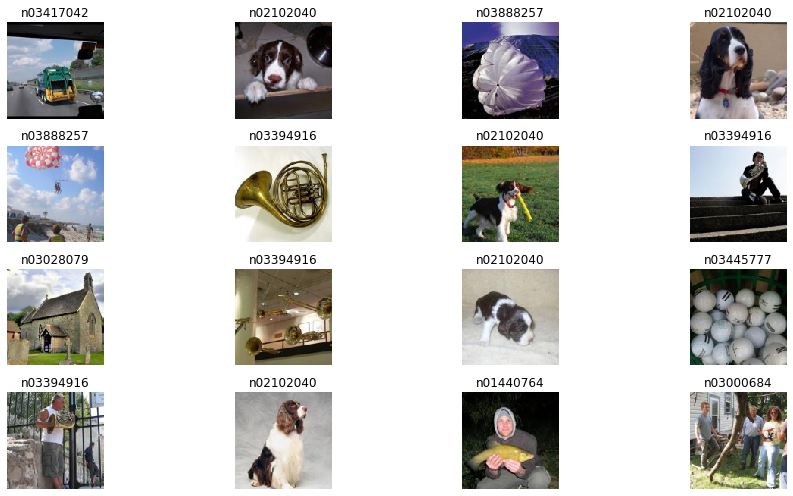

In [24]:
data_imagenette.show_batch(rows=4, figsize=(14, 7))

## VGG architecture

Because ResNet architecture has shortcut connections, it is harder to prune channels as they have to match at different junction points.

Start with VGG architecture to make channel pruning easier.

VGG paper: [Very Deep Convolutional Networks For Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

These VGG networks have been adapted from [PruneTrain CIFAR-10 models](https://bitbucket.org/lph_tools/prunetrain/src/master/src/models/cifar/) which have been designed for 32x32 pixels images.
An additional max pooling layer is added before the linear classifier to reduce the spacial dimension and allow classifying larger images (e.g. 128x128 pixels).

### VGG8

Start with small, fast to train, VGG8 architecture without sparsity.

This will be used as a baseline when experimenting and writing sparsity code.

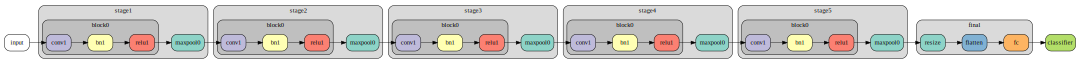

In [22]:
net = VGG8(img_size=128)
display(DotGraph(net))

### VGG16

In [23]:
net = VGG16(img_size=128)
display(DotGraph(net))

## Integrate PruneTrain with Fast.ai

In [25]:
def create_dense_learner(model, data):
    """Create a Learner with a dense model"""
    mark_layers(model)

    epoch_time = TrainTimeMetric()

    metrics = [accuracy, epoch_time]
    callback_fns = [ShowGraph, PeakMemMetric]
    learn = Learner(data, model, opt_func=optim.SGD, metrics=metrics, callback_fns=callback_fns)
    
    return learn

In [26]:
def create_sparse_learner(model, data, group_lasso_ratio=0.2, prune_freq=10, threshold=1e-4, min_w_metric=False):
    mark_layers(model)

    group_lasso_loss = GroupLassoLoss(data.loss_func, model, group_lasso_ratio=group_lasso_ratio)
    sparsity_ch_metric = SparsityChannelsMetric(model)
    epoch_time = TrainTimeMetric()

    metrics = [accuracy, sparsity_ch_metric.sparsity_ch, epoch_time]
    if min_w_metric:
        min_ch_weight_metric = LowestMaxChannelWeightMetric(model)
        metrics.append(min_ch_weight_metric.min_ch_w)

    callback_fns = [ShowGraph, partial(ModelPruner, prune_freq=prune_freq, threshold=threshold), PeakMemMetric]
    learn = Learner(data, model, loss_func=group_lasso_loss, opt_func=optim.SGD, metrics=metrics, callback_fns=callback_fns)
    
    return learn

## Training on the Imagenette dataset

### VGG8

In [28]:
model = build_flat_model(VGG8(img_size=128))
# model_summary(model, torch.randn(1, 3, 128, 128))
model

Sequential(
  (stage1_block0_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage1_block0_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1_block0_relu1): ReLU(inplace)
  (stage1_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (stage2_block0_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage2_block0_bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2_block0_relu1): ReLU(inplace)
  (stage2_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (stage3_block0_conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage3_block0_bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage3_block0_relu1): ReLU(inplace)
  (stage3_maxpool0): MaxPool2d(kernel_size=2, stride=2, p

In [67]:
bs = 64
data_imagenette = create_imagenette_databunch(tfms_nop, bs=bs)

In [30]:
fit_epochs = 25

#### Dense model (baseline)

In [83]:
model = nn.Sequential(build_flat_modules(VGG8(img_size=128)))
learn_imagenette_vgg8 = create_dense_learner(model, data_imagenette)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


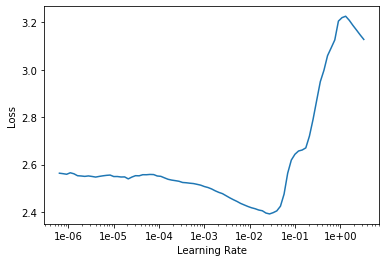

In [84]:
find_lr(learn_imagenette_vgg8)

Note on GPU/CPU memory usage metrics (from [PeakMemMetric](https://docs.fast.ai/callbacks.mem.html) doc):

> The last four columns are deltas memory usage for CPU and GPU (in MBs).
> * The "used memory" columns show the difference between memory usage before and after each epoch.
> * The "peaked memory" columns how much memory overhead the epoch used on top of used memory.


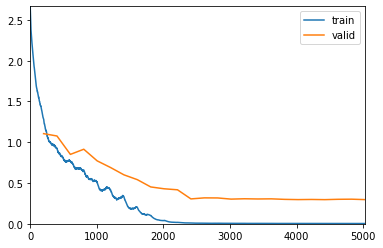

CPU times: user 2min 37s, sys: 1min 33s, total: 4min 11s
Wall time: 4min 19s


In [33]:
%%time
learn_imagenette_vgg8.fit_one_cycle(fit_epochs, max_lr=1e-2)

In [34]:
learn_imagenette_vgg8.save(f"{fmt_now()}_imagenette_vgg8_dense_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190918-081146_imagenette_vgg8_dense_25_epochs.pth')

In [35]:
save_recorder_state(learn_imagenette_vgg8.recorder, f"imagenette_vgg8_dense_{fit_epochs}_epochs")

['20190918-081146_recorder_imagenette_vgg8_dense_25_epochs.lzma']

#### Sparse model

Values from PruneTrain paper: group_lasso_ratio=0.2 threshold=1e-4 prune_freq=10 epochs

In [68]:
model = nn.Sequential(build_flat_modules(VGG8(img_size=128)))
learn_imagenette_vgg8_sparse = create_sparse_learner(model, data_imagenette, group_lasso_ratio=0.2, prune_freq=5, threshold=0.01)

set coef=0.0003883526660501957 loss=2.409531593322754 lasso_penalty=1551.123291015625 group_lasso_ratio=0.2
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


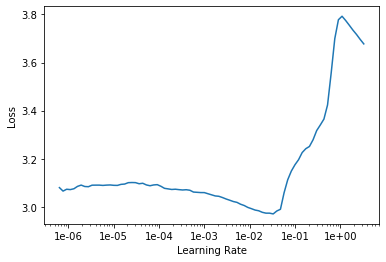

In [69]:
find_lr(learn_imagenette_vgg8_sparse)

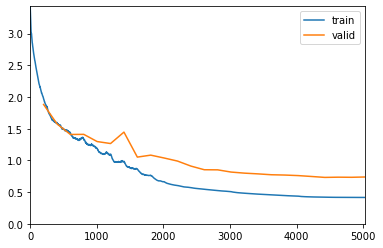

Pruning network at end of epoch 4/25
Pruning network at end of epoch 9/25
Pruning network at end of epoch 14/25
Pruning network at end of epoch 19/25
CPU times: user 2min 51s, sys: 1min 33s, total: 4min 24s
Wall time: 4min 24s


In [52]:
%%time
learn_imagenette_vgg8_sparse.fit_one_cycle(fit_epochs, max_lr=1e-2)

In [53]:
learn_imagenette_vgg8_sparse.save(f"{fmt_now()}_imagenette_vgg8_sparse_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190918-082435_imagenette_vgg8_sparse_25_epochs.pth')

In [54]:
save_recorder_state(learn_imagenette_vgg8_sparse.recorder, f"imagenette_vgg8_sparse_{fit_epochs}_epochs")

['20190918-082435_recorder_imagenette_vgg8_sparse_25_epochs.lzma']

#### Compare models

In [27]:
def metric_values(rec, metric_name, met_idx=None):
    """Return metric values as Numpy array"""
    if met_idx is None:
        met_idx = rec.metrics_names.index(metric_name)
    return np.array([met[met_idx].item() for met in rec.metrics])

In [28]:
def plot_metric(learn, metric_name, met_idx=None, ax=None, label=None):
    """Plot a single Leaner metric"""
    rec = learn.recorder
    
    epochs = list(range(len(rec.nb_batches)))
    
    if met_idx is None:
        met_idx = rec.metrics_names.index(metric_name)
    values = [met[met_idx] for met in rec.metrics]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(epochs, values, label=label)

    ax.set_xlabel("epoch")
    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name}")
    return ax

In [29]:
def plot_cmp_metric(named_learners, metric_name, met_idx=None, ax=None):
    """Plot same metric of several learners on the same 
    chart for comparison
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    for name, learn in named_learners.items():
        plot_metric(learn, metric_name, met_idx=met_idx, ax=ax, label=name)

    ax.legend()

    return ax

In [30]:
def plot_cmp_learner_metrics(named_learners):
    """Plot all metrics of several learners on the same chart"""
    _, learn = next(iter(named_learners.items()))
    for metric_name in learn.recorder.metrics_names:
        ax = plot_cmp_metric(named_learners, metric_name)  

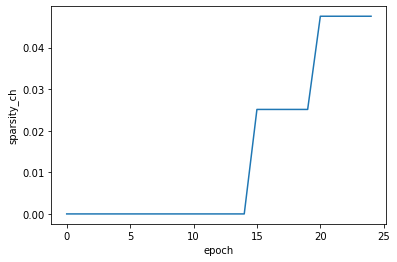

In [59]:
ax = plot_metric(learn_imagenette_vgg8_sparse, "sparsity_ch")

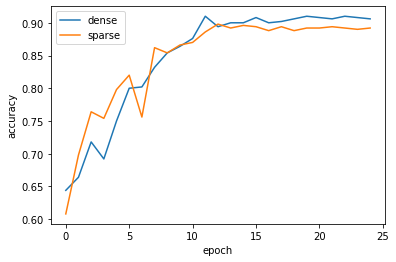

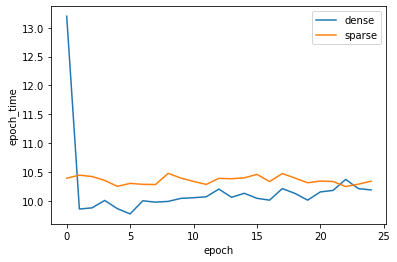

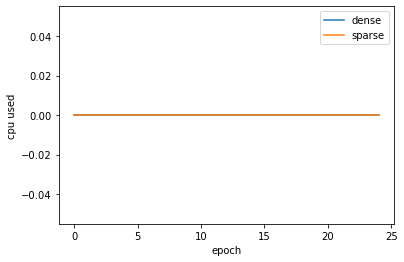

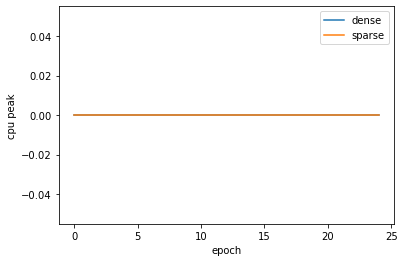

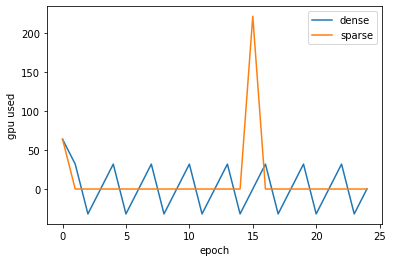

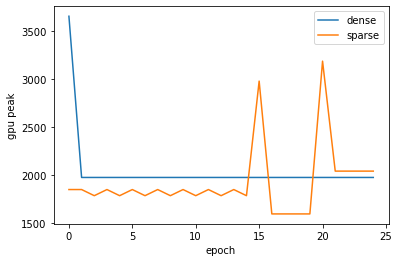

In [60]:
plot_cmp_learner_metrics({"dense": learn_imagenette_vgg8, "sparse": learn_imagenette_vgg8_sparse})

### VGG16

In [31]:
bs = 64
tfms = get_transforms()
data_imagenette = create_imagenette_databunch(tfms, bs=bs)

In [32]:
fit_epochs = 50

In [30]:
model = build_flat_model(VGG16(img_size=128))
model

Sequential(
  (prep_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage1_block0_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage1_block0_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage1_block0_relu1): ReLU(inplace)
  (stage1_maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (stage2_block0_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage2_block0_bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2_block0_relu1): ReLU(inplace)
  (stage2_block1_conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage2_block1_bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2_block1_relu1): ReLU(inplace)
  (stage2_maxpool0): MaxPool2d(kernel_size=2, stride=2, padd

#### Dense model (baseline)

In [42]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
learn_imagenette_vgg16 = create_dense_learner(model, data_imagenette)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


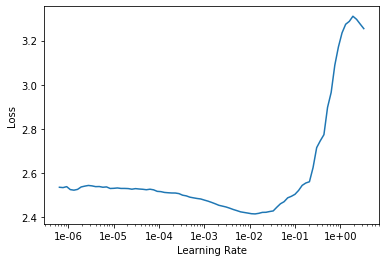

In [43]:
find_lr(learn_imagenette_vgg16)

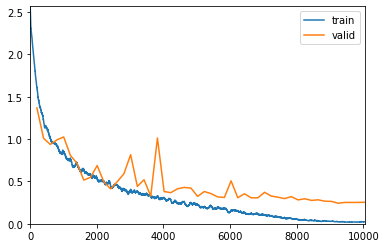

CPU times: user 16min 6s, sys: 7min 9s, total: 23min 15s
Wall time: 19min 40s


In [57]:
%%time
learn_imagenette_vgg16.fit_one_cycle(fit_epochs, max_lr=5e-3)

In [58]:
learn_imagenette_vgg16.save(f"{fmt_now()}_imagenette_vgg16_dense_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190920-093957_imagenette_vgg16_dense_50_epochs.pth')

In [59]:
save_recorder_state(learn_imagenette_vgg16.recorder, f"imagenette_vgg16_dense_{fit_epochs}_epochs")

['20190920-093957_recorder_imagenette_vgg16_dense_50_epochs.lzma']

In [60]:
learn_imagenette_vgg16.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       1,728      True      
______________________________________________________________________
Conv2d               [64, 128, 128]       36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [128, 64, 64]        73,728     True      
______________________________________________________________________
BatchNorm2d          [128, 64, 64]        256        True      
___________________________________________________

#### Sparse model

In [38]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
model_summary(model, torch.randn(1, 3, 128, 128))

prep_conv	Conv2d	torch.Size([1, 64, 128, 128])
stage1_block0_conv1	Conv2d	torch.Size([1, 64, 128, 128])
stage1_block0_bn1	BatchNorm2d	torch.Size([1, 64, 128, 128])
stage1_block0_relu1	ReLU	torch.Size([1, 64, 128, 128])
stage1_maxpool0	MaxPool2d	torch.Size([1, 64, 64, 64])
stage2_block0_conv1	Conv2d	torch.Size([1, 128, 64, 64])
stage2_block0_bn1	BatchNorm2d	torch.Size([1, 128, 64, 64])
stage2_block0_relu1	ReLU	torch.Size([1, 128, 64, 64])
stage2_block1_conv1	Conv2d	torch.Size([1, 128, 64, 64])
stage2_block1_bn1	BatchNorm2d	torch.Size([1, 128, 64, 64])
stage2_block1_relu1	ReLU	torch.Size([1, 128, 64, 64])
stage2_maxpool0	MaxPool2d	torch.Size([1, 128, 32, 32])
stage3_block0_conv1	Conv2d	torch.Size([1, 256, 32, 32])
stage3_block0_bn1	BatchNorm2d	torch.Size([1, 256, 32, 32])
stage3_block0_relu1	ReLU	torch.Size([1, 256, 32, 32])
stage3_block1_conv1	Conv2d	torch.Size([1, 256, 32, 32])
stage3_block1_bn1	BatchNorm2d	torch.Size([1, 256, 32, 32])
stage3_block1_relu1	ReLU	torch.Size([1, 256, 32, 3

In [44]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
learn_imagenette_vgg16_sparse = create_sparse_learner(model, data_imagenette, group_lasso_ratio=0.2, prune_freq=5, threshold=0.015)

set coef=9.706612763693556e-05 loss=2.4103569984436035 lasso_penalty=6208.02783203125 group_lasso_ratio=0.2
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


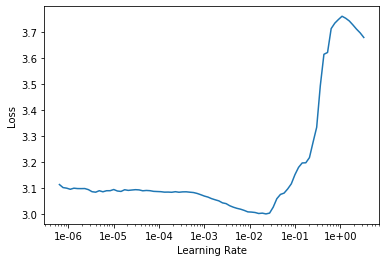

In [45]:
find_lr(learn_imagenette_vgg16_sparse)

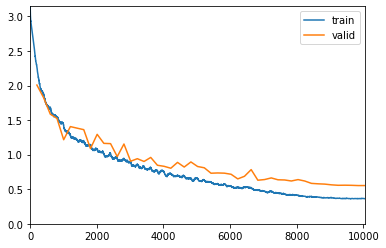

Pruning network at end of epoch 4/50
Pruning network at end of epoch 9/50
Pruning network at end of epoch 14/50
Pruning network at end of epoch 19/50
Pruning network at end of epoch 24/50
Pruning network at end of epoch 29/50
Pruning network at end of epoch 34/50
Pruning network at end of epoch 39/50
Pruning network at end of epoch 44/50
CPU times: user 16min 29s, sys: 6min 54s, total: 23min 23s
Wall time: 19min 56s


In [61]:
%%time
learn_imagenette_vgg16_sparse.fit_one_cycle(fit_epochs, max_lr=5e-3)

In [62]:
learn_imagenette_vgg16_sparse.save(f"{fmt_now()}_imagenette_vgg16_sparse_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190920-095957_imagenette_vgg16_sparse_50_epochs.pth')

In [63]:
save_recorder_state(learn_imagenette_vgg16_sparse.recorder, f"imagenette_vgg16_sparse_{fit_epochs}_epochs")

['20190920-095958_recorder_imagenette_vgg16_sparse_50_epochs.lzma']

In [64]:
learn_imagenette_vgg16_sparse.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       1,728      True      
______________________________________________________________________
Conv2d               [64, 128, 128]       36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [128, 64, 64]        73,728     True      
______________________________________________________________________
BatchNorm2d          [128, 64, 64]        256        True      
___________________________________________________

#### Sparse model with pruning every epoch

In [37]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
model_summary(model, torch.randn(1, 3, 128, 128))

prep_conv	Conv2d	torch.Size([1, 64, 128, 128])
stage1_block0_conv1	Conv2d	torch.Size([1, 64, 128, 128])
stage1_block0_bn1	BatchNorm2d	torch.Size([1, 64, 128, 128])
stage1_block0_relu1	ReLU	torch.Size([1, 64, 128, 128])
stage1_maxpool0	MaxPool2d	torch.Size([1, 64, 64, 64])
stage2_block0_conv1	Conv2d	torch.Size([1, 128, 64, 64])
stage2_block0_bn1	BatchNorm2d	torch.Size([1, 128, 64, 64])
stage2_block0_relu1	ReLU	torch.Size([1, 128, 64, 64])
stage2_block1_conv1	Conv2d	torch.Size([1, 128, 64, 64])
stage2_block1_bn1	BatchNorm2d	torch.Size([1, 128, 64, 64])
stage2_block1_relu1	ReLU	torch.Size([1, 128, 64, 64])
stage2_maxpool0	MaxPool2d	torch.Size([1, 128, 32, 32])
stage3_block0_conv1	Conv2d	torch.Size([1, 256, 32, 32])
stage3_block0_bn1	BatchNorm2d	torch.Size([1, 256, 32, 32])
stage3_block0_relu1	ReLU	torch.Size([1, 256, 32, 32])
stage3_block1_conv1	Conv2d	torch.Size([1, 256, 32, 32])
stage3_block1_bn1	BatchNorm2d	torch.Size([1, 256, 32, 32])
stage3_block1_relu1	ReLU	torch.Size([1, 256, 32, 3

In [77]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
learn_imagenette_vgg16_sparse2 = create_sparse_learner(model, data_imagenette, group_lasso_ratio=0.2, prune_freq=1, threshold=0.015)

set coef=0.00010923316585831344 loss=2.7125978469848633 lasso_penalty=6208.2744140625 group_lasso_ratio=0.2
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


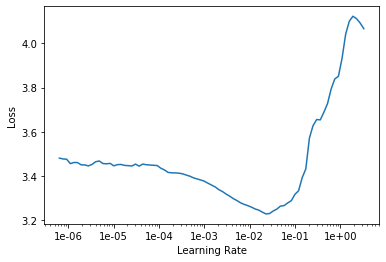

In [47]:
find_lr(learn_imagenette_vgg16_sparse2)

set coef=0.00010439324978506193 loss=2.591843605041504 lasso_penalty=6206.9228515625 group_lasso_ratio=0.2


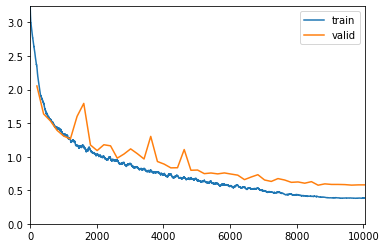

Pruning network at end of epoch 0/50
Pruning network at end of epoch 1/50
Pruning network at end of epoch 2/50
Pruning network at end of epoch 3/50
Pruning network at end of epoch 4/50
Pruning network at end of epoch 5/50
Pruning network at end of epoch 6/50
Pruning network at end of epoch 7/50
Pruning network at end of epoch 8/50
Pruning network at end of epoch 9/50
Pruning network at end of epoch 10/50
Pruning network at end of epoch 11/50
Pruning network at end of epoch 12/50
Pruning network at end of epoch 13/50
Pruning network at end of epoch 14/50
Pruning network at end of epoch 15/50
Pruning network at end of epoch 16/50
Pruning network at end of epoch 17/50
Pruning network at end of epoch 18/50
Pruning network at end of epoch 19/50
Pruning network at end of epoch 20/50
Pruning network at end of epoch 21/50
Pruning network at end of epoch 22/50
Pruning network at end of epoch 23/50
Pruning network at end of epoch 24/50
Pruning network at end of epoch 25/50
Pruning network at end

In [78]:
%%time
learn_imagenette_vgg16_sparse2.fit_one_cycle(fit_epochs, max_lr=5e-3)

In [79]:
learn_imagenette_vgg16_sparse2.save(f"{fmt_now()}_imagenette_vgg16_sparse2_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190920-102211_imagenette_vgg16_sparse2_50_epochs.pth')

In [80]:
save_recorder_state(learn_imagenette_vgg16_sparse2.recorder, f"imagenette_vgg16_sparse2_{fit_epochs}_epochs")

['20190920-102211_recorder_imagenette_vgg16_sparse2_50_epochs.lzma']

In [81]:
learn_imagenette_vgg16_sparse2.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       1,728      True      
______________________________________________________________________
Conv2d               [64, 128, 128]       36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [128, 64, 64]        73,728     True      
______________________________________________________________________
BatchNorm2d          [128, 64, 64]        256        True      
___________________________________________________

#### Compare models

In [33]:
def get_total_train_time(learn):
    """Get total train time from Learner's TrainTimeMetric"""
    for met in learn.metrics:
#         if type(met).__name__ == "TrainTimeMetric":  # work if different class versions
        if isinstance(met, TrainTimeMetric):
            return met.train_total_time   

In [34]:
def get_sum_epoch_time(learn):
    rec = learn.recorder
    met_idx = rec.metrics_names.index("epoch_time")
    times = np.array([met[met_idx] for met in rec.metrics])
    return times.sum()

In [35]:
def print_cmp_total_train_time(learn_dense, learn_sparse):
    total_train_time_dense = get_sum_epoch_time(learn_dense)
    total_train_time_sparse = get_sum_epoch_time(learn_sparse)
    print(f"total_train_time (s):")
    print(f"- dense/sparse: {total_train_time_dense:.2f}/{total_train_time_sparse:.2f}")
    print(f"- sparse delta: {total_train_time_sparse-total_train_time_dense:+.2f}s")
    print(f"- sparse ratio: {total_train_time_sparse / total_train_time_dense:.4f} times dense")    

In [49]:
# load_recorder_state(learn_imagenette_vgg16.recorder, '20190918-094348_recorder_imagenette_vgg16_dense_50_epochs.lzma')
# load_recorder_state(learn_imagenette_vgg16_sparse.recorder, '20190918-092312_recorder_imagenette_vgg16_sparse_50_epochs.lzma')
# load_recorder_state(learn_imagenette_vgg16_sparse2.recorder, '20190919-084527_recorder_imagenette_vgg16_sparse2_50_epochs.lzma')

In [65]:
print_cmp_total_train_time(learn_imagenette_vgg16, learn_imagenette_vgg16_sparse)

total_train_time (s):
- dense/sparse: 1168.19/1180.79
- sparse delta: +12.60s
- sparse ratio: 1.0108 times dense


In [82]:
print_cmp_total_train_time(learn_imagenette_vgg16, learn_imagenette_vgg16_sparse2)

total_train_time (s):
- dense/sparse: 1168.19/1172.15
- sparse delta: +3.96s
- sparse ratio: 1.0034 times dense


In [36]:
def count_parameters(model):
    """Count model parameters. 
    Source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
def print_cmp_param_count(learn_dense, learn_sparse):
    param_count_dense = count_parameters(learn_dense.model)
    param_count_sparse = count_parameters(learn_sparse.model)
    print(f"Total trainable params:")
    print(f"- dense       : {param_count_dense:,}")
    print(f"- sparse      : {param_count_sparse:,}")
    print(f"- sparse ratio: {param_count_sparse / param_count_dense:.4f} times dense")    

In [84]:
print_cmp_param_count(learn_imagenette_vgg16, learn_imagenette_vgg16_sparse)

Total trainable params:
- dense       : 20,034,890
- sparse      : 11,587,879
- sparse ratio: 0.5784 times dense


In [83]:
print_cmp_param_count(learn_imagenette_vgg16, learn_imagenette_vgg16_sparse2)

Total trainable params:
- dense       : 20,034,890
- sparse      : 11,277,660
- sparse ratio: 0.5629 times dense


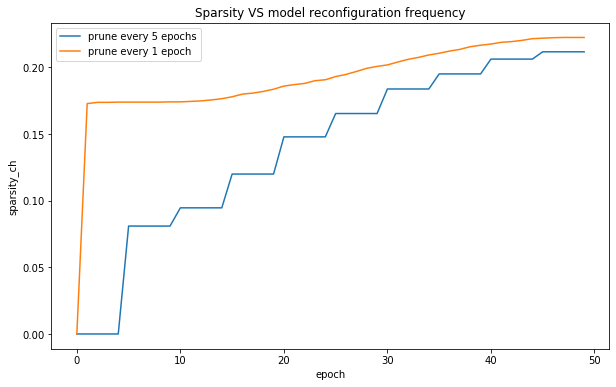

In [85]:
ax = plot_cmp_metric({"prune every 5 epochs": learn_imagenette_vgg16_sparse, "prune every 1 epoch": learn_imagenette_vgg16_sparse2}, "sparsity_ch")
_ = ax.set_title("Sparsity VS model reconfiguration frequency")

In [86]:
named_learners = {"dense": learn_imagenette_vgg16, "sparse/5 epochs": learn_imagenette_vgg16_sparse, "sparse/1 epochs": learn_imagenette_vgg16_sparse2}

In [71]:
def print_max_accuracy(named_learners):
    print("Max accuracy:")
    for name, learn in named_learners.items():
        max_acc = metric_values(learn.recorder, "accuracy").max()
        print(f"- {name}: {max_acc:.4f}")    

In [87]:
print_max_accuracy(named_learners)

Max accuracy:
- dense: 0.9400
- sparse/5 epochs: 0.9420
- sparse/1 epochs: 0.9360


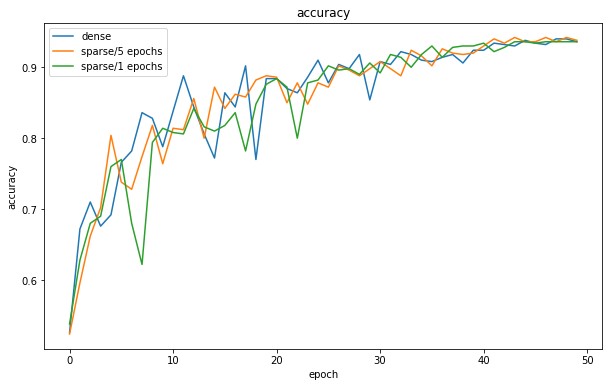

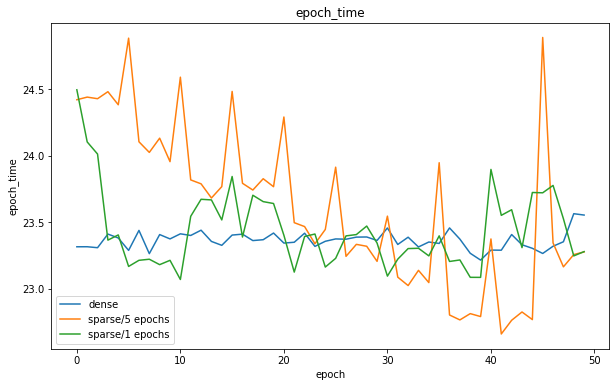

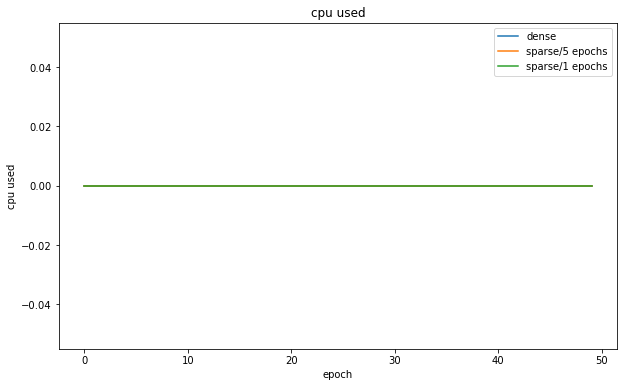

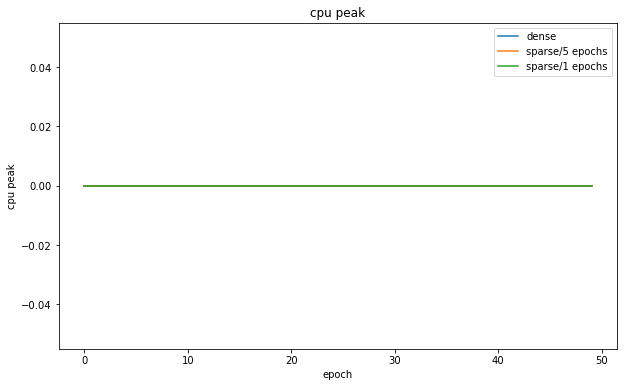

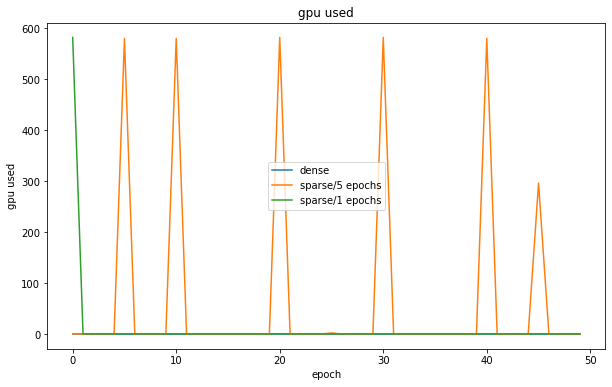

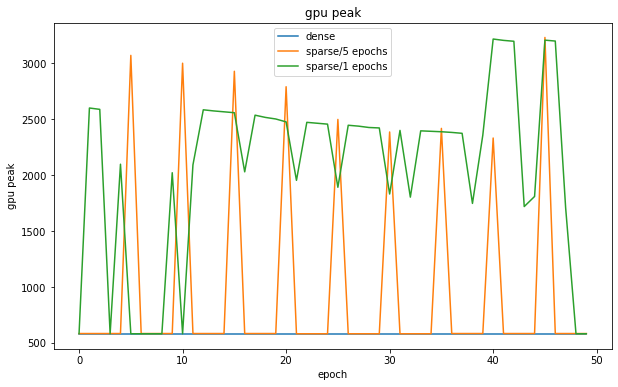

In [88]:
plot_cmp_learner_metrics(named_learners)

## Group lasso regularizer without pruning

In [38]:
model = nn.Sequential(build_flat_modules(VGG16(img_size=128)))
learn_imagenette_vgg16_lasso = create_sparse_learner(model, data_imagenette, group_lasso_ratio=0.2, prune_freq=999, 
                                                    threshold=0.015, min_w_metric=True)

set coef=0.00010760588338598609 loss=2.67151141166687 lasso_penalty=6206.7041015625 group_lasso_ratio=0.2


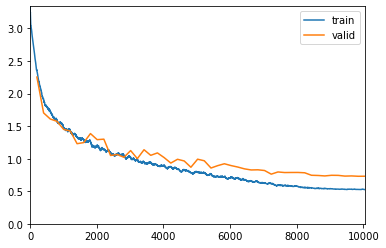

CPU times: user 17min 4s, sys: 7min 24s, total: 24min 29s
Wall time: 20min 34s


In [39]:
%%time
learn_imagenette_vgg16_lasso.fit_one_cycle(fit_epochs, max_lr=5e-3)

In [40]:
learn_imagenette_vgg16_lasso.save(f"{fmt_now()}_imagenette_vgg16_lasso_{fit_epochs}_epochs", return_path=True)

PosixPath('/home/jupyter/.fastai/data/imagenette-160/models/20190920-075955_imagenette_vgg16_lasso_50_epochs.pth')

In [41]:
save_recorder_state(learn_imagenette_vgg16_lasso.recorder, f"imagenette_vgg16_lasso_{fit_epochs}_epochs")

['20190920-075955_recorder_imagenette_vgg16_lasso_50_epochs.lzma']

### Compare with previous models

In [89]:
named_learners = {
    "dense": learn_imagenette_vgg16, 
    "sparse/5 epochs": learn_imagenette_vgg16_sparse, 
    "sparse/1 epochs": learn_imagenette_vgg16_sparse2,
    "group lasso": learn_imagenette_vgg16_lasso,
}

In [90]:
print_cmp_total_train_time(learn_imagenette_vgg16, learn_imagenette_vgg16_lasso)

total_train_time (s):
- dense/sparse: 1168.19/1222.70
- sparse delta: +54.50s
- sparse ratio: 1.0467 times dense


In [91]:
print_max_accuracy(named_learners)

Max accuracy:
- dense: 0.9400
- sparse/5 epochs: 0.9420
- sparse/1 epochs: 0.9360
- group lasso: 0.9380


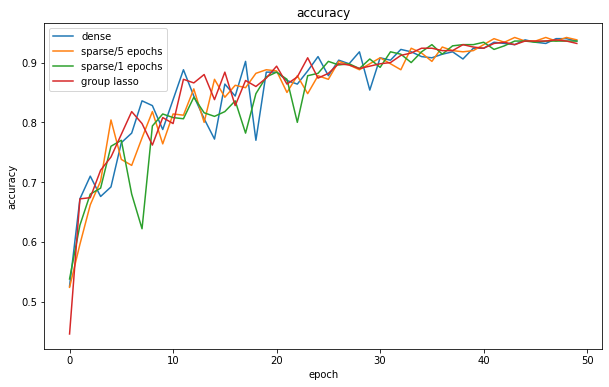

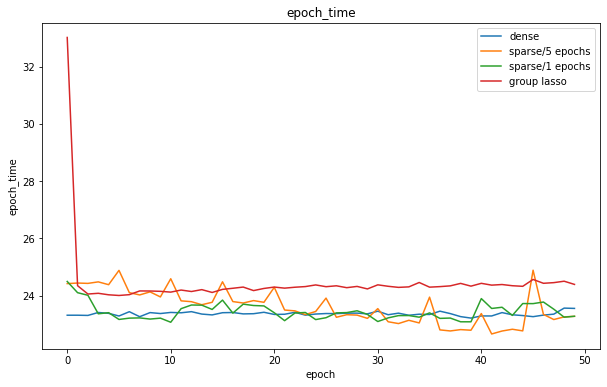

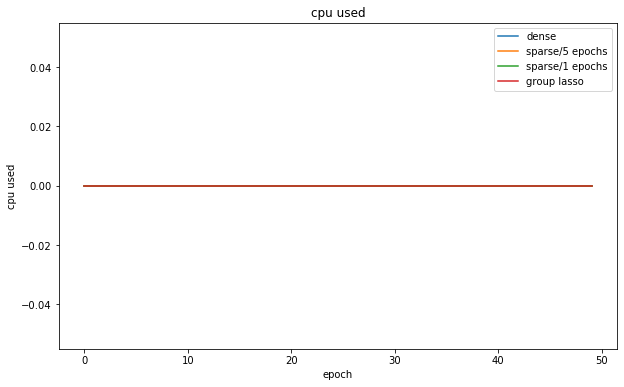

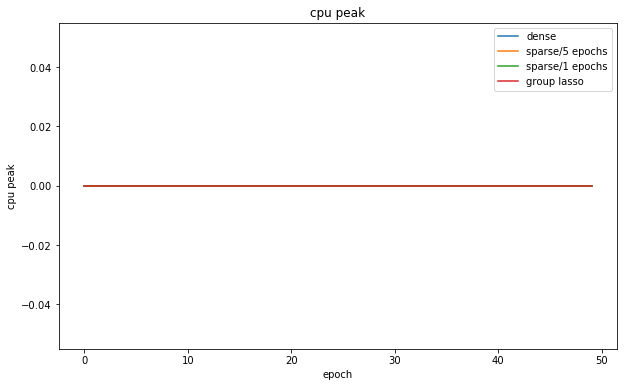

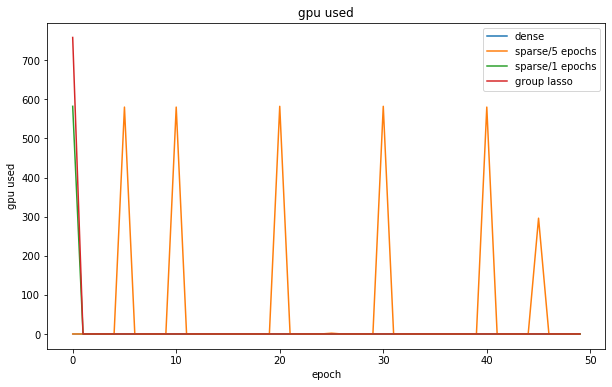

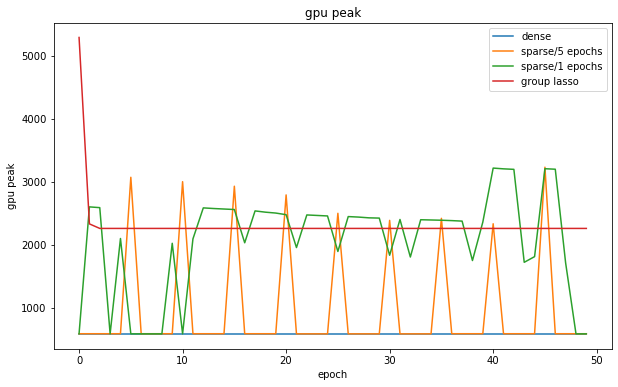

In [92]:
plot_cmp_learner_metrics(named_learners)